# Part 1 - Tradition Image processing for classification: feature extraction

The notebook is an educational experiment rather than a competitive one. The notebook explores traditional image processing methods for extracting features from images to use in classification. I've only used a subset of available techniques here, several other features can also be derived from the images.

Needless to mention, modern deep learning approaches will perform significantly better. It was fun to play around.

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as dcm
%matplotlib inline 
plt.set_cmap(plt.cm.bone)
IS_LOCAL = True
import os
import cv2
import skimage
from skimage import feature, filters
from tqdm import tqdm

PATH="../input/rsna-pneumonia-detection-challenge"

print(os.listdir(PATH))

In [ ]:
class_info_df = pd.read_csv(PATH+'/stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv(PATH+'/stage_2_train_labels.csv')
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

In [ ]:
train_class_df.head()

## Utility functions

In [ ]:
def load_images(data):
    imgs = []
    for path in data['patientId']:
        patientImage = path + '.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/", patientImage)
        img = dcm.read_file(imagePath).pixel_array
        imgs.append(img)
    return imgs

def imshow_gray(img):
    plt.figure(figsize=(12,7))
    return plt.imshow(img, cmap='gray')
    
def imshow_with_labels(img, patient_id):
    rows = train_labels_df[train_labels_df['patientId'] == patient_id]
    for row in rows.itertuples():        
        x, y, w, h = row.x, row.y, row.width, row.height
        x, y, w, h = map(int, [x,y,w,h])
        cv2.rectangle(img, (x,y), (x+w,y+h), 255, 2)
    plt.figure(figsize=(12,7))
    return plt.imshow(img, cmap='gray')

## Sample a few images and process them

In [ ]:
test_df = train_class_df[train_class_df['Target']==1].sample(4)
box = test_df.loc[test_df.index, ['x', 'y', 'width', 'height']]
test = load_images(test_df[0:3])

In [ ]:
idx = 1
img = test[idx]
imshow_with_labels(img.copy(), test_df.iloc[idx,0])

## Image enhancement

### Histogram equalization

In [ ]:
equ = cv2.equalizeHist(test[idx])
ax = imshow_gray(equ)

Equalization presents a good contrast of the lungs, and further accents the presence of opacity

### Image sharpening

In [ ]:
# apply hpf kernel
hpf_kernel = np.full((3, 3), -1)
hpf_kernel[1,1] = 9
im_hp = cv2.filter2D(equ, -1, hpf_kernel)

# use unsharpen mask filter
im_us = skimage.filters.unsharp_mask(equ)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
ax1.imshow(im_hp, cmap='gray')
ax1.set_title('High pass filter')
ax2.imshow(im_us, cmap='gray')
ax2.set_title('unsharpen mask filter')
fig.suptitle('Image sharpening')

High pass show more detail, while unmask is still a little blurry, not ideal for feature extraction

### Thresholding


In [ ]:
# otsu thresholding
ret, otsu = cv2.threshold(cv2.GaussianBlur(im_hp,(7,7),0),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# local thresholding
local = im_hp > skimage.filters.threshold_local(im_hp, 5)
mean = im_hp > skimage.filters.threshold_mean(im_hp)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,9))
ax1.imshow(otsu, cmap='gray')
ax1.set_title('Otsu thresholding')
ax2.imshow(local, cmap='gray')
ax2.set_title('Local thresholding')
fig.suptitle('Image sharpening')
ax3.imshow(mean, cmap='gray')
ax3.set_title('Mean thresholding')
fig.suptitle('Image thresholding')

Otsu thresholding helps extract smooth edges, so we choose it and it segments the lungs portion better

### Edge detection

In [ ]:
sobel = filters.sobel(otsu)
canny = feature.canny(otsu/255)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
ax1.imshow(canny, cmap='gray')
ax1.set_title('Canny edge detection')
ax2.imshow(sobel, cmap='gray')
ax2.set_title('Sobel operator')
fig.suptitle('Edge detection')

Sobel fiter extracts the edges better than canny

### Lung segmentation

Find and pull out contours

In [ ]:
contours, hier = cv2.findContours((sobel * 255).astype('uint8'),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
print('Contours found ', len(contours))

srt_contours = sorted(contours, key=lambda x: x.shape[0], reverse=True)
select_contour = srt_contours[0]  # probably not the best assumption

test = img.copy()
img_contour = cv2.drawContours(test, [select_contour], 0, (255,0,0), thickness=3)

imshow_gray(img_contour)

After identifying the lung segment we can extract the center of moment of this segment. Since, all the X-ray images are from the same dimension, this can be a valid feature for prediction

In [ ]:
M = cv2.moments(select_contour)
cx = int(M['m10'] / M['m00'])
cy = int(M["m01"] / M["m00"])

test = img.copy()
cv2.circle(test, (cx, cy), 7, (255, 255, 255), -1)
imshow_gray(test)

But there are images were the subject is slightly rotated, and differently sized so we want center of moment to be invariant to rotation and scale. So we pick **Hu moments**. We will also log the moments to make it easy to compare and drop the 3rd moment as it depends on the other moments and 7th moment as it distinguishes mirror images and there are no flipped images in the dataset

In [ ]:
def get_hu_moments(contour):
    M = cv2.moments(select_contour)
    hu = cv2.HuMoments(M).ravel().tolist()
    del hu[2]
    del hu[-1]
    log_hu = [-np.sign(a)*np.log10(np.abs(a)) for a in hu]
    return log_hu

get_hu_moments(select_contour)

## Feature extraction
We derive the following features from our above results to build a classifier for pneumonia detection:
* Area of opacity
* Perimeter of visible lung regions
* Irregularity index
* Equivalent diameter
* Mean, sd of unenhanced image
* Hu moments
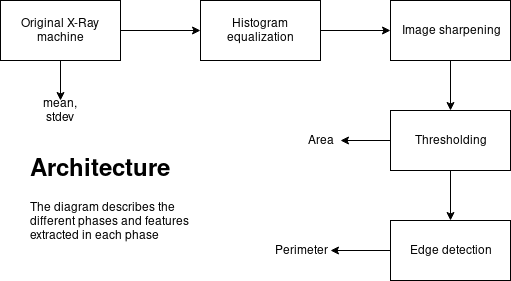

In [ ]:
def area(img):
    # binarized image as input
    return np.count_nonzero(img)

def perimeter(img):
    # edges of the image as input
    return np.count_nonzero(img)

def irregularity(area, perimeter):
    # area and perimeter of the image as input, also called compactness
    I = (4 * np.pi * area) / (perimeter ** 2)
    return I

def equiv_diam(area):
    # area of image as input
    ed = np.sqrt((4 * area) / np.pi)
    return ed

def get_hu_moments(contour):
    # hu moments except 3rd and 7th (5 values)
    M = cv2.moments(contour)
    hu = cv2.HuMoments(M).ravel().tolist()
    del hu[2]
    del hu[-1]
    log_hu = [-np.sign(a)*np.log10(np.abs(a)) for a in hu]
    return log_hu

### The image preprocessing and feature extraction pipeline

In [ ]:
def extract_features(img):
    mean = img.mean()
    std_dev = img.std()
    
    # hist equalization
    equalized = cv2.equalizeHist(img)
    
    # sharpening
    hpf_kernel = np.full((3, 3), -1)
    hpf_kernel[1,1] = 9
    sharpened = cv2.filter2D(equalized, -1, hpf_kernel)
    
    # thresholding
    ret, binarized = cv2.threshold(cv2.GaussianBlur(sharpened,(7,7),0),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # edge detection
    edges = skimage.filters.sobel(binarized)
    
    # moments from contours
    contours, hier = cv2.findContours((edges * 255).astype('uint8'),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    select_contour = sorted(contours, key=lambda x: x.shape[0], reverse=True)[0]
    
    # feature extraction
    ar = area(binarized)
    per = perimeter(edges)
    irreg = irregularity(ar, per)
    eq_diam = equiv_diam(ar)
    hu = get_hu_moments(select_contour)
    
    return (mean, std_dev, ar, per, irreg, eq_diam, *hu)

In [ ]:
# test the function
extract_features(img)

# Save generated features

## Load the required data
We select only the normal and pneumonia images for model building

In [ ]:
pneumonia_ids = train_labels_df[train_labels_df['Target'] == 1]['patientId'].unique()
pneumonia_labels = [1] * len(pneumonia_ids)

normal_ids = class_info_df[class_info_df['class'] == 'Normal']['patientId'].unique()
normal_labels = [0] * len(normal_ids)

data = dict()
data['patientId'] = np.concatenate((pneumonia_ids, normal_ids))
data['target'] = np.concatenate((pneumonia_labels, normal_labels))

print(f'Pneumonia images: {len(pneumonia_ids)}\nNormal images: {len(normal_ids)}')

## Generate features
For each ID generate the features from the image and store it in the dataset

In [ ]:
from tqdm import tqdm

In [ ]:
features = []

for path in tqdm(data['patientId']):
    patientImage = path + '.dcm'
    imagePath = os.path.join(PATH,"stage_2_train_images/", patientImage)
    img = dcm.read_file(imagePath).pixel_array
    feats = extract_features(img)
    features.append(feats)

data['features'] = features

In [ ]:
df = pd.DataFrame(data)
df.to_csv('img_features.csv')

After the features are generated, they can be loaded and trained using machine learning models to perform classification. Results with different ML algorithms are presented in the the [2nd part of this notebook](https://www.kaggle.com/suryathiru/2-tradition-image-processing-model-training)